# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Task 3 second approach
## Alessandro Cesa

This Notebook contains the code for the first approach to task 3 of the project.

At first the necessary libraries have to be imported.

In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.models.alexnet import AlexNet_Weights
from sklearn.svm import LinearSVC

In [2]:
#Adjust according to your path
import sys
sys.path.append('/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/functions') #Adjust according to your path

from image_handling_functions import *
from train_test_functions import *
from neural_networks import *

Then we'll load the dataset

In [3]:
%%capture 
#Run if you don't already have the dataset
"""
!git clone https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa.git
"""

In [4]:
#Adjust according to your path
train_path = "/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/CVPR2023_project_2_and_3_data/train"
test_path = "/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/CVPR2023_project_2_and_3_data/test"

We get the device (CPU or GPU)

In [5]:
device = get_default_device()

Set the seeds for reproducibility

In [6]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

The data sets have to be transformed, using the ImageFolder function

In [7]:
train=ImageFolder(root=train_path,transform=transformation_for_AlexNet)
test=ImageFolder(root=test_path,transform=transformation_for_AlexNet)

We'll now create the Data Loaders, and perform data augmentation.

In [8]:
batch_size = 32

augmented_train=TransformedDataSet(train)
concatenated_dataset = torch.utils.data.ConcatDataset([train, augmented_train])
train_loader = DataLoader(concatenated_dataset, batch_size=batch_size,shuffle=True,pin_memory=True)

test_loader = DataLoader(test, batch_size=batch_size,shuffle=False,pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Now we'll first extract the features using AlexNet

In [9]:
model=models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
for param in model.parameters():
    param.requires_grad = False

In [10]:
train_features,train_labels=extract_for_svm(model,train_loader,device)
test_features,test_labels=extract_for_svm(model,test_loader,device)

Time for extraction: 7.312652349472046
Time for extraction: 6.785296201705933


And then feed those features to a Support Vector Machine

In [11]:
svm=LinearSVC(random_state=123)

In [12]:
%%time
svm.fit(train_features,train_labels)

/orfeo/cephfs/home/dssc/acesa000/cv_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


CPU times: user 8.32 s, sys: 12 ms, total: 8.33 s
Wall time: 8.35 s


/orfeo/cephfs/home/dssc/acesa000/cv_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=123)

Accuracy on test images is 0.7963149078726968


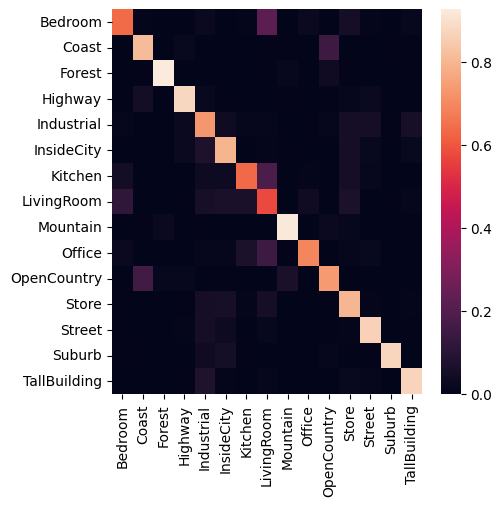

In [13]:
test_svm(svm,test_features,test_labels,test)